# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from math import comb
import pickle
from typing import List, Set, Tuple
import random

import os

# Load and Save Data
- 640 total examples
- 270/370 - train/test split
- 9 speakers total
- each sample is a timeseries of a varying length in the range of 7 to 29
- each point of the time series has 12 features - the coefficients
- in the training set each speaker has 30 recording blocks
- in the test set each speaker has the following number of vowel recording blocks: [31 35 88 44 29 24 40 50 29] 

Note: I verified that the matlab code and the code below produce identical results

In [2]:
def load_ae_data(train_file='data\\ae.train', test_file='data\\ae.test'):
    """
    Load and parse the ape call data from ASCII files.
    
    Returns:
    - train_inputs: list of numpy arrays (270 time series, each N x 12)
    - test_inputs: list of numpy arrays (370 time series, each N x 12) 
    - train_outputs: list of numpy arrays (270 time series, each N x 9)
    - test_outputs: list of numpy arrays (370 time series, each N x 9)
    - N is the length of the time series, varying per sample
    """
    
    # Load the data
    ae_train = np.loadtxt(train_file)
    ae_test = np.loadtxt(test_file)
    
    # Parse training data
    train_inputs = []
    read_index = 0
    
    for c in range(270):
        start_index = read_index
        # Find the length of current time series (until we hit a row of 1.0s)
        while read_index < len(ae_train) and ae_train[read_index, 0] != 1.0:
            read_index += 1
        
        # Extract the time series
        time_series = ae_train[start_index:read_index, :]
        train_inputs.append(time_series)
        
        # Skip the separator row of 1.0s
        read_index += 1
    
    # Parse test data
    test_inputs = []
    read_index = 0
    
    for c in range(370):
        start_index = read_index
        # Find the length of current time series
        while read_index < len(ae_test) and ae_test[read_index, 0] != 1.0:
            read_index += 1
        
        # Extract the time series
        time_series = ae_test[start_index:read_index, :]
        test_inputs.append(time_series)
        
        # Skip the separator row of 1.0s
        read_index += 1
    
    # Generate teacher signals (outputs)
    train_outputs = []
    for c in range(270):
        length = len(train_inputs[c])
        teacher = np.zeros((length, 9))
        speaker_index = c // 30  # 30 samples per speaker, 9 speakers total
        teacher[:, speaker_index] = 1
        train_outputs.append(teacher)
    
    test_outputs = []
    speaker_index = 0
    block_counter = 0
    block_lengths = [31, 35, 88, 44, 29, 24, 40, 50, 29]  # samples per speaker in test set
    
    for c in range(370):
        if block_counter == block_lengths[speaker_index]:
            speaker_index += 1
            block_counter = 0
        
        length = len(test_inputs[c])
        teacher = np.zeros((length, 9))
        teacher[:, speaker_index] = 1
        test_outputs.append(teacher)
        
        block_counter += 1
    
    return train_inputs, test_inputs, train_outputs, test_outputs

## Save 

In [3]:
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Load the data
train_inputs, test_inputs, train_outputs, test_outputs = load_ae_data()

# Save the data as separate pickle files
with open('data/train_inputs.pkl', 'wb') as f:
    pickle.dump(train_inputs, f)
with open('data/test_inputs.pkl', 'wb') as f:
    pickle.dump(test_inputs, f)
with open('data/train_outputs.pkl', 'wb') as f:
    pickle.dump(train_outputs, f)
with open('data/test_outputs.pkl', 'wb') as f:
    pickle.dump(test_outputs, f)

## Example loading saved data

In [4]:
def load_saved_data(data_folder='data'):
    """
    Load the preprocessed ape call data from pickle files.
    
    Args:
        data_folder (str): Path to the folder containing pickle files
        
    Returns:
        tuple: (train_inputs, test_inputs, train_outputs, test_outputs)
    """
    try:
        with open(f'{data_folder}/train_inputs.pkl', 'rb') as f:
            train_inputs = pickle.load(f)
        with open(f'{data_folder}/test_inputs.pkl', 'rb') as f:
            test_inputs = pickle.load(f)
        with open(f'{data_folder}/train_outputs.pkl', 'rb') as f:
            train_outputs = pickle.load(f)
        with open(f'{data_folder}/test_outputs.pkl', 'rb') as f:
            test_outputs = pickle.load(f)
        
        print(f"Data loaded successfully from {data_folder}/")
        print(f"Train samples: {len(train_inputs)}, Test samples: {len(test_inputs)}")
        print(f"Input dimensions: {train_inputs[0].shape[1]}, Output dimensions: {train_outputs[0].shape[1]}")
        
        return train_inputs, test_inputs, train_outputs, test_outputs
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

In [5]:
# Example usage for other notebooks:
train_inputs, test_inputs, train_outputs, test_outputs = load_saved_data()

Data loaded successfully from data/
Train samples: 270, Test samples: 370
Input dimensions: 12, Output dimensions: 9


# EDA

- Just some quick prints to get familiar with the data

In [6]:
# Display data shapes and statistics
print("=== SANITY CHECK ===")
print(f"Number of training time series: {len(train_inputs)}")
print(f"Number of test time series: {len(test_inputs)}")
print(f"Input dimensionality: {train_inputs[0].shape[1]}")
print(f"Output dimensionality: {train_outputs[0].shape[1]}")

print("\n=== TRAINING DATA ===")
train_lengths = [ts.shape[0] for ts in train_inputs]
print(f"Time series lengths - Min: {min(train_lengths)}, Max: {max(train_lengths)}, Mean: {np.mean(train_lengths):.1f}")

print("\n=== TEST DATA ===")
test_lengths = [ts.shape[0] for ts in test_inputs]
print(f"Time series lengths - Min: {min(test_lengths)}, Max: {max(test_lengths)}, Mean: {np.mean(test_lengths):.1f}")

print("\n=== AVG TRAIN SAMPLE LENGTH PER SPEAKER ===")
print("Training data (30 samples per speaker):")
for speaker in range(9):
    start_idx = speaker * 30
    end_idx = (speaker + 1) * 30
    speaker_lengths = [len(train_inputs[i]) for i in range(start_idx, end_idx)]
    print(f"Speaker {speaker + 1}: {len(speaker_lengths)} samples, avg length: {np.mean(speaker_lengths):.1f}")


print("\n=== SAMPLE DATA SHAPES ===")
print("First 5 training samples:")
for i in range(5):
    print(f"Sample {i+1}: Input {train_inputs[i].shape}, Output {train_outputs[i].shape}")

print("\nFirst 5 test samples:")
for i in range(5):
    print(f"Sample {i+1}: Input {test_inputs[i].shape}, Output {test_outputs[i].shape}")

# Display sample data values
print("\n=== SAMPLE INPUT VALUES ===")
print("First training sample (first 5 time steps):")
print(train_inputs[0][:5])

print("\nCorresponding output (first 5 time steps):")
print(train_outputs[0][:5])

=== SANITY CHECK ===
Number of training time series: 270
Number of test time series: 370
Input dimensionality: 12
Output dimensionality: 9

=== TRAINING DATA ===
Time series lengths - Min: 7, Max: 26, Mean: 15.8

=== TEST DATA ===
Time series lengths - Min: 7, Max: 29, Mean: 15.4

=== AVG TRAIN SAMPLE LENGTH PER SPEAKER ===
Training data (30 samples per speaker):
Speaker 1: 30 samples, avg length: 18.1
Speaker 2: 30 samples, avg length: 15.5
Speaker 3: 30 samples, avg length: 14.1
Speaker 4: 30 samples, avg length: 20.2
Speaker 5: 30 samples, avg length: 13.2
Speaker 6: 30 samples, avg length: 17.4
Speaker 7: 30 samples, avg length: 16.9
Speaker 8: 30 samples, avg length: 12.6
Speaker 9: 30 samples, avg length: 14.5

=== SAMPLE DATA SHAPES ===
First 5 training samples:
Sample 1: Input (20, 12), Output (20, 9)
Sample 2: Input (26, 12), Output (26, 9)
Sample 3: Input (22, 12), Output (22, 9)
Sample 4: Input (20, 12), Output (20, 9)
Sample 5: Input (21, 12), Output (21, 9)

First 5 test s

- we see that some speakers on average have shorter sequence lengths compared to others.

## Distriubtion of lengths

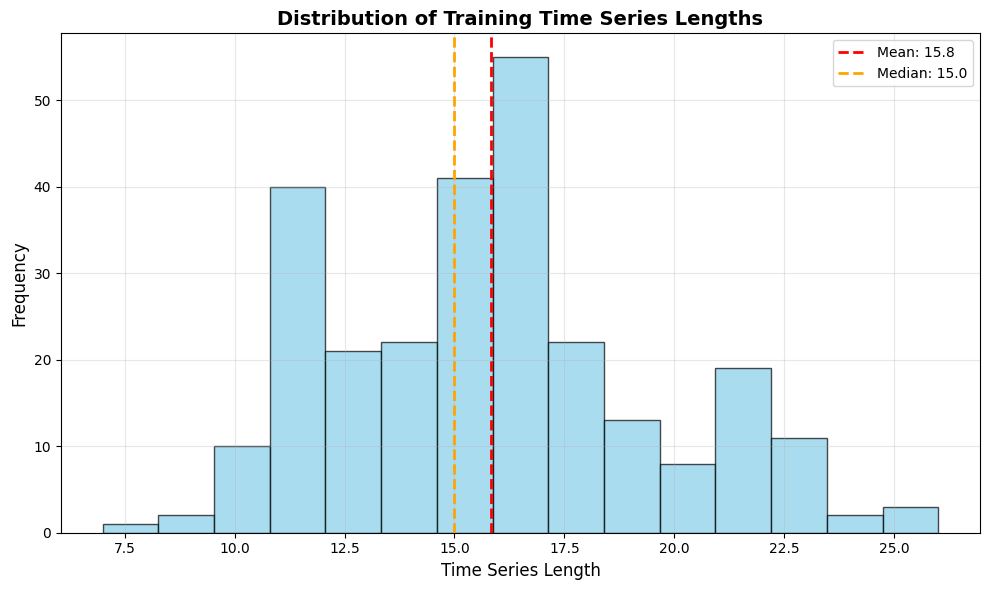

Training time series length statistics:
Min: 7, Max: 26
Mean: 15.8, Median: 15.0
Standard deviation: 3.6


In [7]:
# Visualization of training time series lengths
plt.figure(figsize=(10, 6))
train_lengths = [ts.shape[0] for ts in train_inputs]

plt.hist(train_lengths, bins=15, alpha=0.7, edgecolor='black', color='skyblue')
plt.title('Distribution of Training Time Series Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Time Series Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics as text
mean_length = np.mean(train_lengths)
median_length = np.median(train_lengths)
plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:.1f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Training time series length statistics:")
print(f"Min: {min(train_lengths)}, Max: {max(train_lengths)}")
print(f"Mean: {mean_length:.1f}, Median: {median_length:.1f}")
print(f"Standard deviation: {np.std(train_lengths):.1f}")

## Visualize all 12 dim

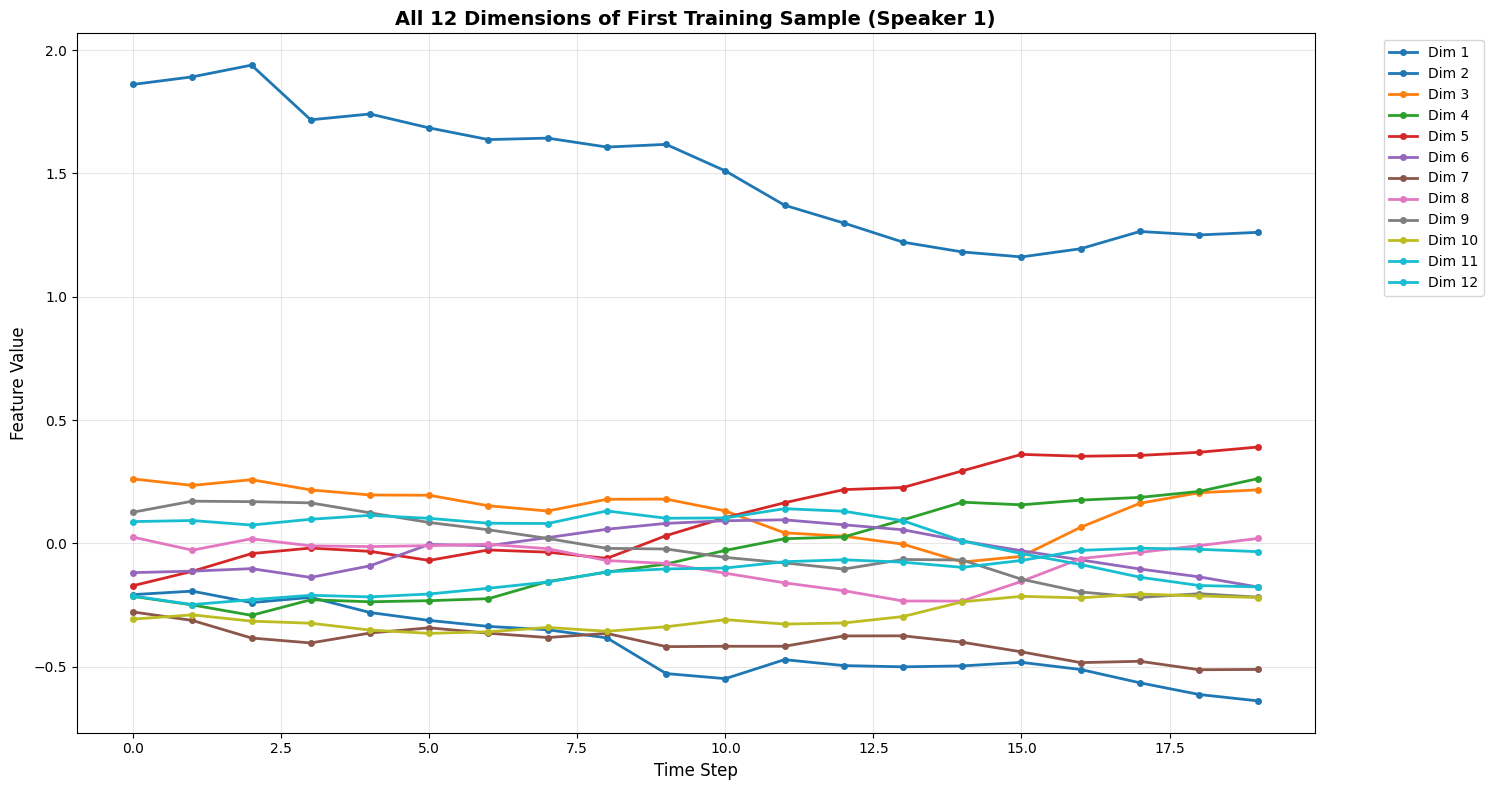

First training sample info:
Shape: (20, 12)
Speaker: 1
Length: 20 time steps
Feature value ranges:
  Dim 1: [1.162, 1.939]
  Dim 2: [-0.638, -0.193]
  Dim 3: [-0.075, 0.262]
  Dim 4: [-0.291, 0.263]
  Dim 5: [-0.171, 0.391]
  Dim 6: [-0.177, 0.096]
  Dim 7: [-0.512, -0.278]
  Dim 8: [-0.234, 0.026]
  Dim 9: [-0.219, 0.171]
  Dim 10: [-0.364, -0.205]
  Dim 11: [-0.248, -0.019]
  Dim 12: [-0.176, 0.141]


In [8]:
# Visualization of all 12 dimensions for the first training sample
plt.figure(figsize=(15, 8))

# Get the first training sample
sample_data = train_inputs[0]
time_steps = range(len(sample_data))

# Define colors for each dimension
colors = plt.cm.tab10(np.linspace(0, 1, 12))

# Plot all 12 dimensions
for dim in range(12):
    plt.plot(time_steps, sample_data[:, dim], 
             color=colors[dim], 
             linewidth=2, 
             marker='o', 
             markersize=4,
             label=f'Dim {dim + 1}')

plt.title('All 12 Dimensions of First Training Sample (Speaker 1)', fontsize=14, fontweight='bold')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Feature Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"First training sample info:")
print(f"Shape: {sample_data.shape}")
print(f"Speaker: {np.argmax(train_outputs[0][0]) + 1}")
print(f"Length: {len(sample_data)} time steps")
print(f"Feature value ranges:")
for dim in range(12):
    min_val = np.min(sample_data[:, dim])
    max_val = np.max(sample_data[:, dim])
    print(f"  Dim {dim + 1}: [{min_val:.3f}, {max_val:.3f}]")

## Distriubtion per speaker and dimension
- Are there any clearly distinct patterns in speaker coefficient distributions?

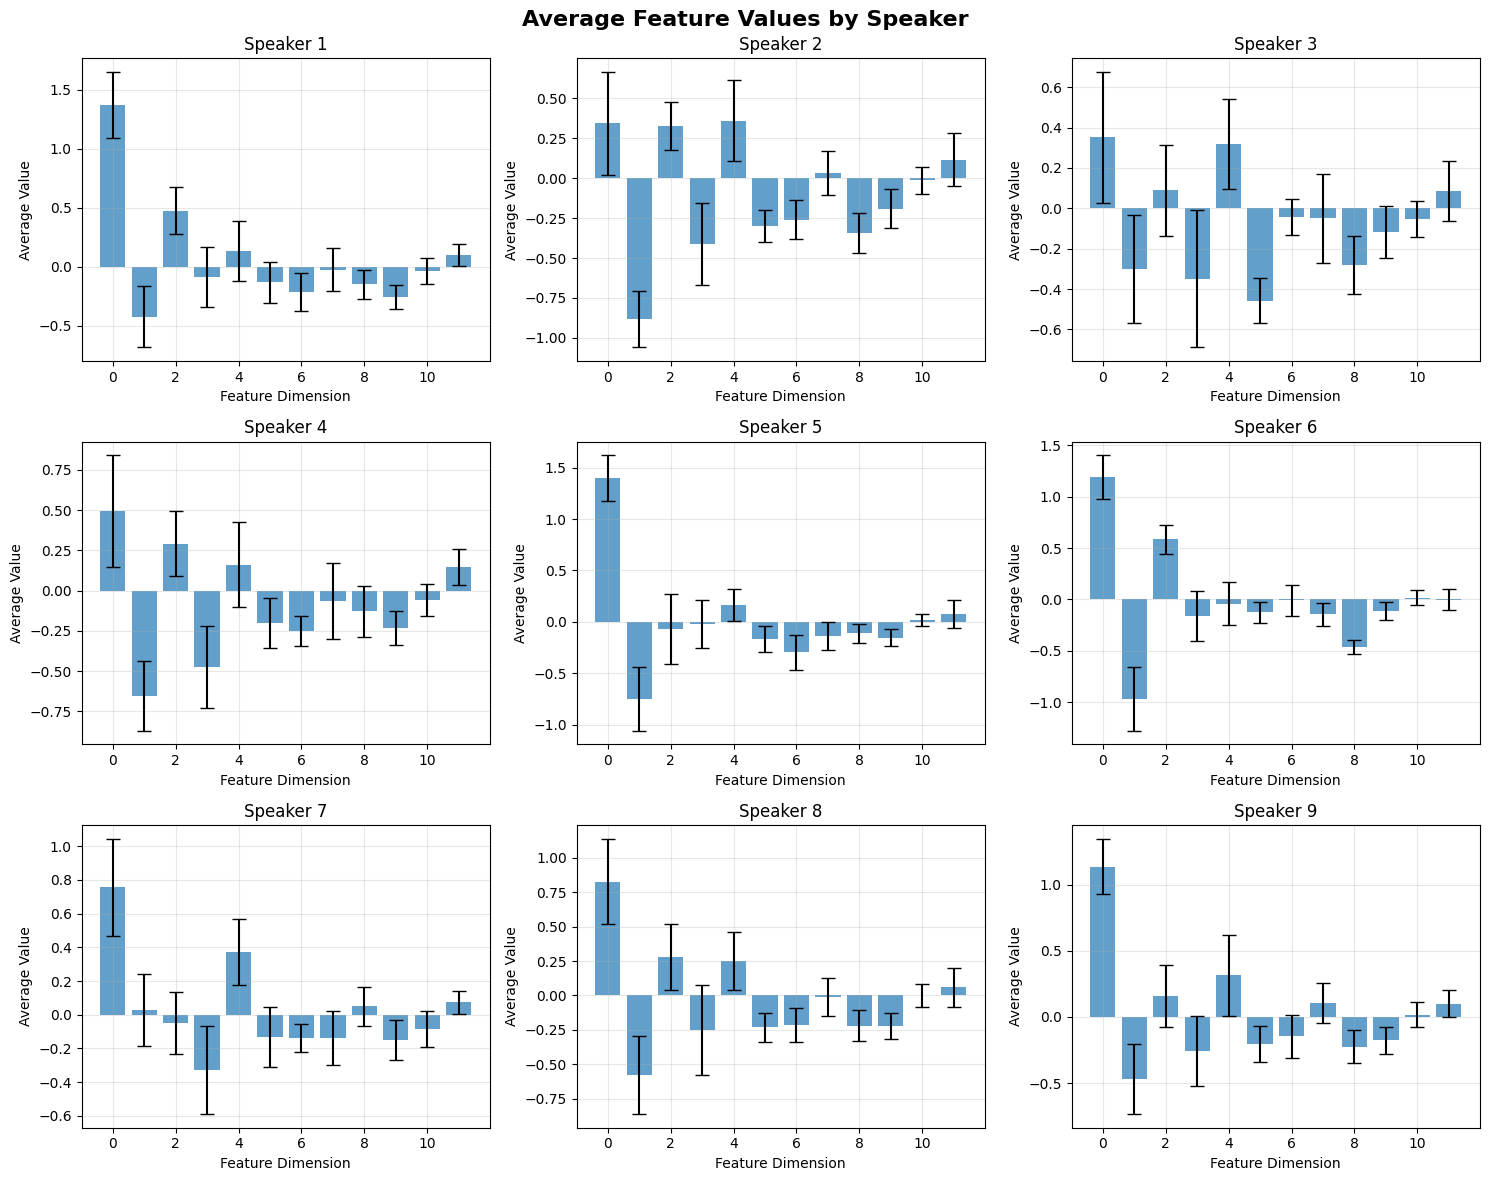

In [9]:
# Speaker-specific analysis - feature distributions per speaker
def analyze_speaker_features():
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Average Feature Values by Speaker', fontsize=16, fontweight='bold')
    
    speaker_means = []
    speaker_stds = []
    
    for speaker in range(9):
        # Get all samples for this speaker
        start_idx = speaker * 30
        end_idx = (speaker + 1) * 30
        speaker_data = np.vstack([train_inputs[i] for i in range(start_idx, end_idx)])
        
        # Calculate mean and std for each dimension
        means = np.mean(speaker_data, axis=0)
        stds = np.std(speaker_data, axis=0)
        speaker_means.append(means)
        speaker_stds.append(stds)
        
        # Plot
        row, col = speaker // 3, speaker % 3
        axes[row, col].bar(range(12), means, yerr=stds, alpha=0.7, capsize=5)
        axes[row, col].set_title(f'Speaker {speaker + 1}')
        axes[row, col].set_xlabel('Feature Dimension')
        axes[row, col].set_ylabel('Average Value')
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return np.array(speaker_means), np.array(speaker_stds)

speaker_means, speaker_stds = analyze_speaker_features()

## Basic PCA Analysis

### Methodology
For each of the 270 training sequences, extracted simple statistical features:
- **Mean** of each of the 12 coefficients
- **Standard deviation** of each of the 12 coefficients  
- **Sequence length** 1 feature
- **Total**: 25 features per sequence

- Next scale these features and apply PCA for dimensionality reduction.

### Results
- The first two principal components (PC1 + PC2) explain about **31%** of the total variance
- While we can observe some clustering patterns by speaker in the 2D PCA plot, the relatively low variance capture means we cannot draw deep conclusions about speaker separability from this analysis alone


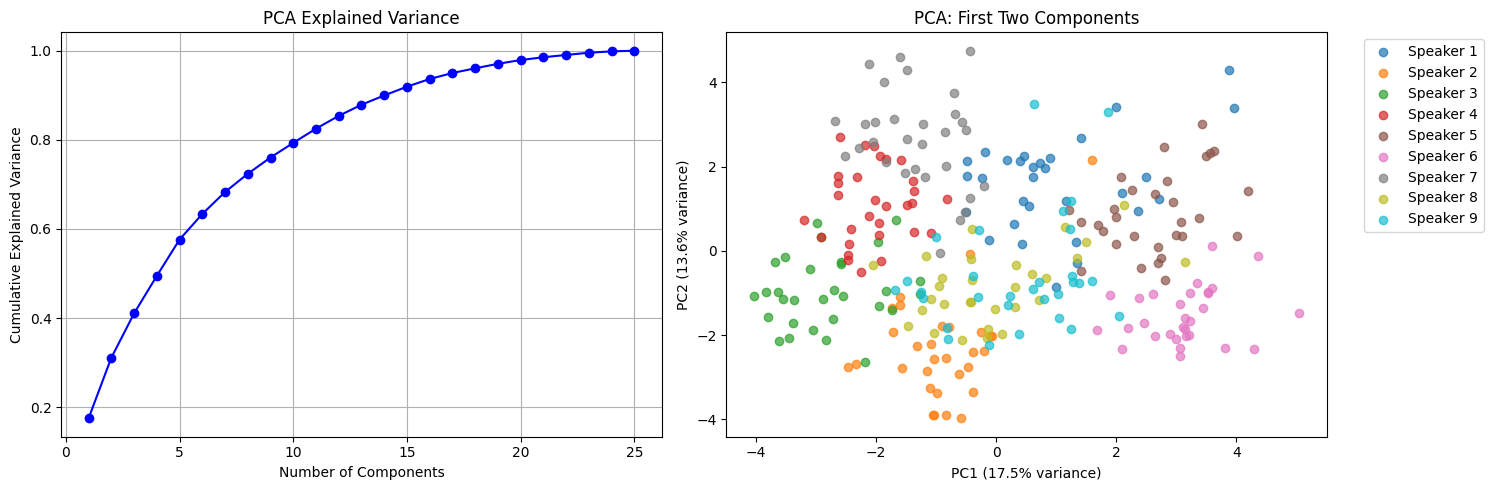

In [10]:
# Basci PCA analysis
def analyze_pca():
    feature_vectors = []
    speaker_labels = []
    
    for i, sample in enumerate(train_inputs):
        # Use statistical summaries as features
        mean_features = np.mean(sample, axis=0)
        std_features = np.std(sample, axis=0)
        sequence_length = len(sample)
        
        # Combine all features: 12 means + 12 stds + 1 length = 25 features
        combined_features = np.concatenate([mean_features, std_features, [sequence_length]])
        feature_vectors.append(combined_features)
        speaker_labels.append(i // 30)
    
    
    feature_vectors = np.array(feature_vectors)
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_vectors)
    
    # Apply PCA
    pca = PCA()
    pca_features = pca.fit_transform(scaled_features)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Explained variance
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    
    # 2D PCA plot
    plt.subplot(1, 2, 2)
    colors = plt.cm.tab10(np.linspace(0, 1, 9))
    for speaker in range(9):
        mask = np.array(speaker_labels) == speaker
        plt.scatter(pca_features[mask, 0], pca_features[mask, 1], 
                   c=[colors[speaker]], label=f'Speaker {speaker+1}', alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('PCA: First Two Components')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    
    plt.tight_layout()
    plt.show()
    
analyze_pca()

# Binning method

In [162]:
U = 6
V = 22

In [163]:
def create_binning_grid(train_inputs, U=4, V=20):
    """
    Create the binning grid with U time thresholds and V feature thresholds.
    
    Args:
        train_inputs: list of numpy arrays (270 time series, each N x 12)
        U: number of equally spaced time thresholds
        V: number of equally spaced feature thresholds per dimension
    
    Returns:
        time_thresholds: array of U time threshold values
        feature_thresholds: array of shape (12, V) with threshold values for each feature
    """
    # Find maximum time length across all training samples
    max_length = max(len(sample) for sample in train_inputs)
    
    # Create equally spaced time thresholds from 0 to max_length
    time_thresholds = np.linspace(0, max_length, U)
    
    # For each of the 12 features, find min and max values across all samples
    all_data = np.vstack(train_inputs)  # Concatenate all training data
    
    feature_thresholds = np.zeros((12, V))
    for dim in range(12):
        min_val = np.min(all_data[:, dim])
        max_val = np.max(all_data[:, dim])
        feature_thresholds[dim] = np.linspace(min_val, max_val, V)
    
    return time_thresholds, feature_thresholds

In [164]:
time_thresholds, feature_thresholds = create_binning_grid(train_inputs, U, V)

- Check if the threshold and shape make sense

In [165]:
print(time_thresholds)

[ 0.   5.2 10.4 15.6 20.8 26. ]


In [166]:
print(feature_thresholds.shape)

(12, 22)


- Sanity Check - confirm that the first feature is correctly divided into equally spaced regions

In [167]:
all_data = np.vstack(train_inputs)  # Concatenate all training data
min_val_feature_1 = np.min(all_data[:, 0])  # First feature (index 0)
max_val_feature_1 = np.max(all_data[:, 0])

print(f"Feature 1 - Min: {min_val_feature_1:.3f}, Max: {max_val_feature_1:.3f}")

Feature 1 - Min: -0.784, Max: 2.203


- if we know Min: -0.784, Max: 2.203 then those should be the first and last vlaues. In addtion 2.203 + 0.704 is abou 2.987. 2.987/19 is ~0.157 - this should be the difference between consecutive samples - which is true here

In [168]:
print(feature_thresholds[0])

[-0.783783   -0.64154852 -0.49931405 -0.35707957 -0.2148451  -0.07261062
  0.06962386  0.21185833  0.35409281  0.49632729  0.63856176  0.78079624
  0.92303071  1.06526519  1.20749967  1.34973414  1.49196862  1.6342031
  1.77643757  1.91867205  2.06090652  2.203141  ]


In [169]:
def curve_to_binary_vector(curve, time_thresholds, feature_thresholds, K=1):
    """
    Convert a single time series curve to binary vector using the binning method.
    
    Args:
        curve: numpy array of shape (N, D) representing one time series
        time_thresholds: array of U time threshold values
        feature_thresholds: array of shape (D, V) with threshold values for each feature
        K: minimum number of times curve must pass through rectangle (1 in paper)
    
    Returns:
        binary_vector: binary vector representing the curve
    """
    U = len(time_thresholds)
    V = feature_thresholds.shape[1]
    n_dims = curve.shape[1]  # Get actual number of dimensions from the curve
    
    # Calculate number of possible rectangles per dimension
    # We choose any 2 time thresholds and any 2 feature thresholds
    from math import comb
    n_time_rectangles = comb(U, 2)  # U choose 2
    n_feature_rectangles = comb(V, 2)  # V choose 2
    n_rectangles_per_dim = n_time_rectangles * n_feature_rectangles
    
    # Binary vector length: n_dims × n_rectangles_per_dim × K × 2
    total_length = n_dims * n_rectangles_per_dim * K * 2
    binary_vector = np.zeros(total_length, dtype=int)
    
    bit_index = 0
    
    for dim in range(n_dims):
        feature_values = curve[:, dim]
        time_steps = np.arange(len(curve))
        
        # Generate all possible time intervals (choose 2 from U thresholds)
        for t_pair in combinations(range(U), 2):
            t_start = time_thresholds[t_pair[0]]
            t_end = time_thresholds[t_pair[1]]
            
            # Generate all possible feature intervals (choose 2 from V thresholds)
            for f_pair in combinations(range(V), 2):
                f_start = feature_thresholds[dim, f_pair[0]]
                f_end = feature_thresholds[dim, f_pair[1]]
                
                # Count how many points fall within this rectangle
                time_mask = (time_steps >= t_start) & (time_steps <= t_end)
                feature_mask = (feature_values >= f_start) & (feature_values <= f_end)
                points_in_rectangle = np.sum(time_mask & feature_mask)
                
                # For each k from 1 to K
                for k in range(1, K + 1):
                    # Check if curve passes through rectangle at least k times
                    passes_through = 1 if points_in_rectangle >= k else 0
                    
                    # Set the bit
                    binary_vector[bit_index] = passes_through
                    bit_index += 1
                    
                    # Set the inverted bit
                    binary_vector[bit_index] = 1 - passes_through
                    bit_index += 1
    
    return binary_vector

- Following the formula from the paper: B = 2nK(U 2)(V 2)

In [170]:
U = 4
V = 20
K = 1
n_dims = 12

n_time_rectangles = comb(U, 2)  # 4 choose 2 = 6
n_feature_rectangles = comb(V, 2)  # 20 choose 2 = 190
n_rectangles_per_dim = n_time_rectangles * n_feature_rectangles  # 6 * 190 = 1140
total_bits = n_dims * n_rectangles_per_dim * K * 2  # 12 * 1140 * 1 * 2 = 27,360

print(f"U choose 2: {n_time_rectangles}")
print(f"V choose 2: {n_feature_rectangles}")
print(f"Rectangles per dimension: {n_rectangles_per_dim}")
print(f"Expected total bit length: {total_bits}")

U choose 2: 6
V choose 2: 190
Rectangles per dimension: 1140
Expected total bit length: 27360


In [171]:
binary_vectors = []
for i, curve in enumerate(train_inputs):
    if i % 50 == 0:
        print(f"Processing curve {i+1}/270...")
    
    binary_vec = curve_to_binary_vector(curve, time_thresholds, feature_thresholds, K)
    binary_vectors.append(binary_vec)

binary_vectors = np.array(binary_vectors)

Processing curve 1/270...
Processing curve 51/270...
Processing curve 101/270...
Processing curve 151/270...
Processing curve 201/270...
Processing curve 251/270...


- As expected we have processed 270 curves / samples each with a binary vector of length 27360 - for U=4 and V=20 - can vary with different configurations

In [172]:
print(f"Binary vectors shape: {binary_vectors.shape}")

Binary vectors shape: (270, 83160)


In [173]:
print(binary_vectors[0][:50])

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1
 0 1 0 1 0 0 1 0 1 0 1 0 1]


- Rectangle 0: Time [0.0, 2.0], Feature [0.0, 0.5] - small bottom left
- Rectangle 1: Time [0.0, 2.0], Feature [0.0, 1.0] - big left
- Rectangle 2: Time [0.0, 2.0], Feature [0.5, 1.0] - small top left
- Rectangle 3: Time [0.0, 4.0], Feature [0.0, 0.5] - big bottom
- Rectangle 4: Time [0.0, 4.0], Feature [0.0, 1.0] - whole grid
- Rectangle 5: Time [0.0, 4.0], Feature [0.5, 1.0] - big top
- Rectangle 6: Time [2.0, 4.0], Feature [0.0, 0.5] - small bottom right
- Rectangle 7: Time [2.0, 4.0], Feature [0.0, 1.0] - big right
- Rectangle 8: Time [2.0, 4.0], Feature [0.5, 1.0] - small top right

=== SIMPLE BINNING EXAMPLE ===
Time thresholds: [0. 2. 4.]
Feature thresholds: [0.  0.5 1. ]


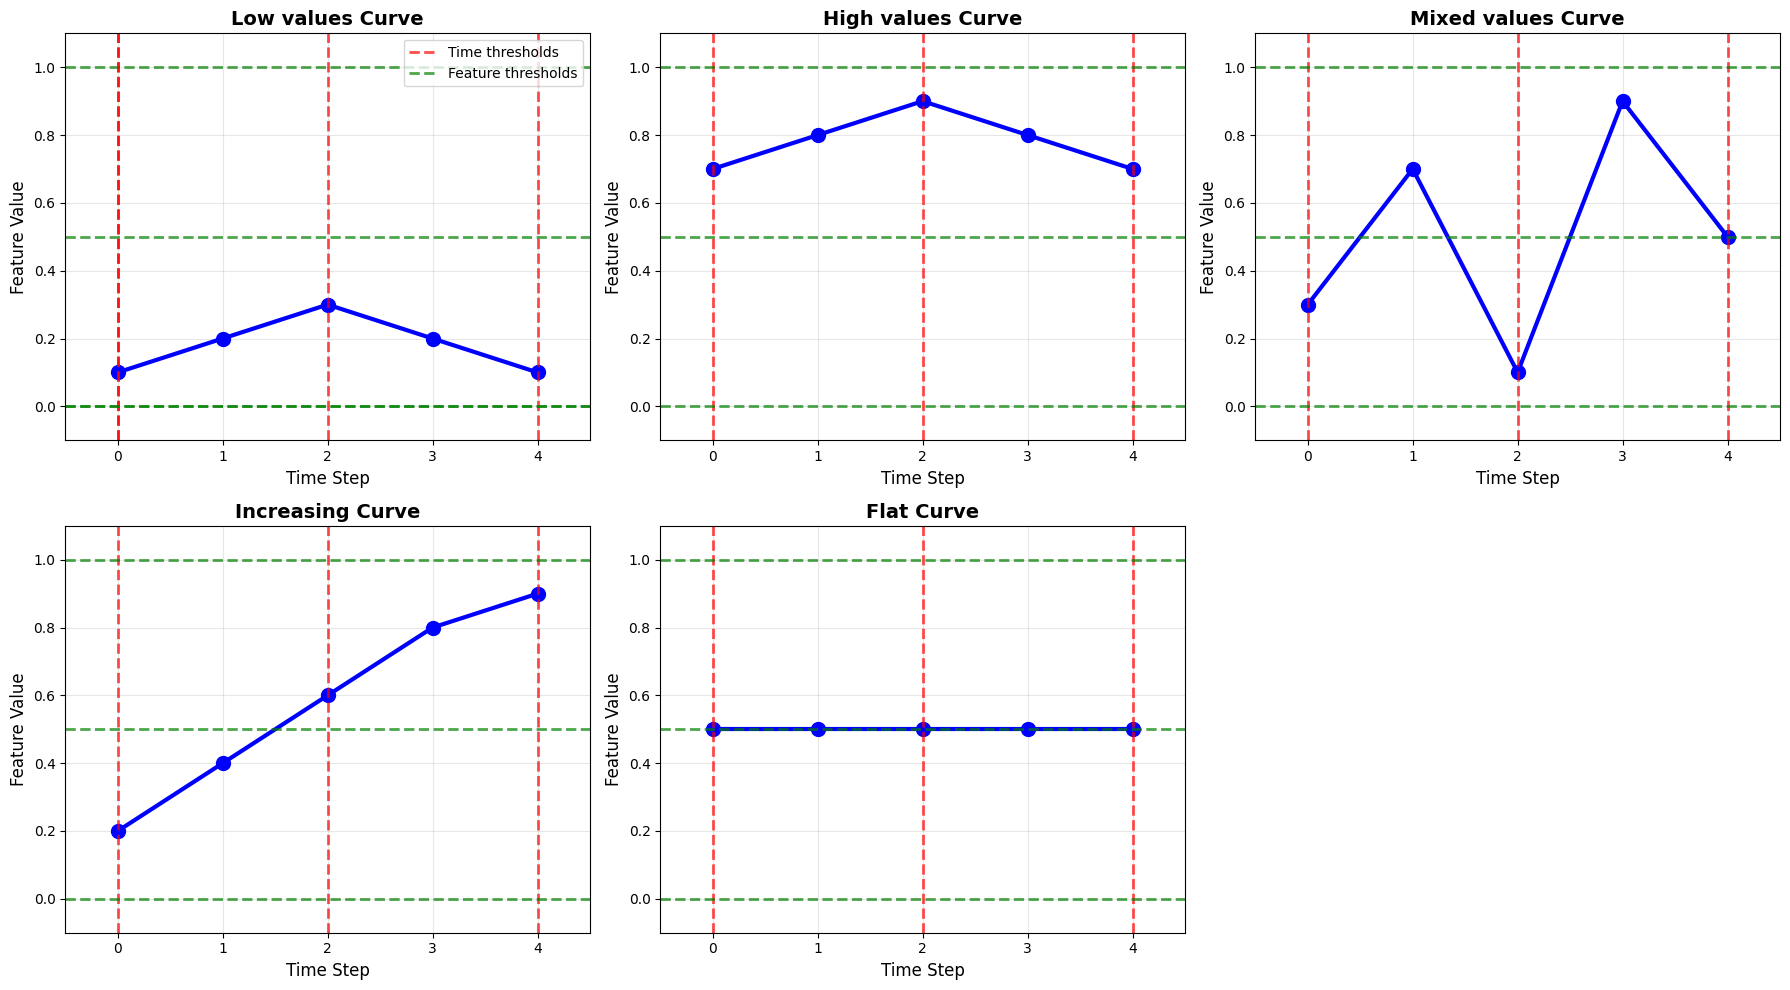


=== LOW VALUES CURVE ===
Curve values: [0.1 0.2 0.3 0.2 0.1]
Binary vector: [1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1]

=== HIGH VALUES CURVE ===
Curve values: [0.7 0.8 0.9 0.8 0.7]
Binary vector: [0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0]

=== MIXED VALUES CURVE ===
Curve values: [0.3 0.7 0.1 0.9 0.5]
Binary vector: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]

=== INCREASING CURVE ===
Curve values: [0.2 0.4 0.6 0.8 0.9]
Binary vector: [1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0]

=== FLAT CURVE ===
Curve values: [0.5 0.5 0.5 0.5 0.5]
Binary vector: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]

=== BINARY VECTOR COMPARISON ===
Low values  : [1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1]
High values : [0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0]
Mixed values: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
Increasing  : [1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0]
Flat        : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


In [174]:
# Simple visual example to verify the binning method
def simple_binning_example():
    # Define multiple example curves
    curve_examples = {
        'Low values': np.array([[0.1], [0.2], [0.3], [0.2], [0.1]]),
        'High values': np.array([[0.7], [0.8], [0.9], [0.8], [0.7]]),
        'Mixed values': np.array([[0.3], [0.7], [0.1], [0.9], [0.5]]),
        'Increasing': np.array([[0.2], [0.4], [0.6], [0.8], [0.9]]),
        'Flat': np.array([[0.5], [0.5], [0.5], [0.5], [0.5]])
    }
    
    # Simple grid: U=3 time thresholds, V=3 feature thresholds  
    U, V = 3, 3
    max_time = 4  # 0 to 4 time steps
    
    # Create thresholds
    time_thresholds = np.linspace(0, max_time, U)  # [0, 2, 4]
    
    # Feature thresholds for our single dimension
    min_val, max_val = 0.0, 1.0
    feature_thresholds = np.array([np.linspace(min_val, max_val, V)])  # [[0, 0.5, 1.0]]
    
    print("=== SIMPLE BINNING EXAMPLE ===")
    print(f"Time thresholds: {time_thresholds}")
    print(f"Feature thresholds: {feature_thresholds[0]}")
    
    # Create subplot for each curve
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    all_results = {}
    
    for idx, (curve_name, simple_curve) in enumerate(curve_examples.items()):
        if idx >= 5:
            break
            
        ax = axes[idx]
        
        # Plot the time series with grid
        ax.plot(range(len(simple_curve)), simple_curve[:, 0], 'bo-', linewidth=3, markersize=10)
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('Feature Value', fontsize=12)
        ax.set_title(f'{curve_name} Curve', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-0.5, 4.5)
        ax.set_ylim(-0.1, 1.1)
        
        # Add threshold lines
        for thresh in time_thresholds:
            ax.axvline(thresh, color='red', linestyle='--', alpha=0.7, linewidth=2)
        for thresh in feature_thresholds[0]:
            ax.axhline(thresh, color='green', linestyle='--', alpha=0.7, linewidth=2)
        

        if idx == 0:  # Only add legend to first plot
            ax.axvline(time_thresholds[0], color='red', linestyle='--', alpha=0.7, linewidth=2, label='Time thresholds')
            ax.axhline(feature_thresholds[0][0], color='green', linestyle='--', alpha=0.7, linewidth=2, label='Feature thresholds')
            ax.legend()
        
        # Generate rectangle info and test our function
        rectangle_info = []
        rect_id = 0
        time_points = np.arange(len(simple_curve))
        
        for t_pair in combinations(range(U), 2):
            for f_pair in combinations(range(V), 2):
                t_start = time_thresholds[t_pair[0]]
                t_end = time_thresholds[t_pair[1]]
                f_start = feature_thresholds[0, f_pair[0]]
                f_end = feature_thresholds[0, f_pair[1]]
                
                # Count points in rectangle
                time_mask = (time_points >= t_start) & (time_points <= t_end)
                feature_mask = (simple_curve[:, 0] >= f_start) & (simple_curve[:, 0] <= f_end)
                points_in_rect = np.sum(time_mask & feature_mask)
                
                rectangle_info.append({
                    'id': rect_id,
                    't_range': (t_start, t_end),
                    'f_range': (f_start, f_end),
                    'points': points_in_rect
                })
                rect_id += 1
        
        # Test our function
        binary_vec = curve_to_binary_vector(simple_curve, time_thresholds, feature_thresholds, K=1)
        
        # Store results
        all_results[curve_name] = {
            'curve': simple_curve,
            'rectangles': rectangle_info,
            'binary_vector': binary_vec
        }
    
    # Remove the last subplot if we have fewer than 6 examples
    if len(curve_examples) < 6:
        fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis for each curve
    for curve_name, results in all_results.items():
        print(f"\n=== {curve_name.upper()} CURVE ===")
        print(f"Curve values: {results['curve'].flatten()}")
        print(f"Binary vector: {results['binary_vector']}")
        
    # Compare binary vectors
    print(f"\n=== BINARY VECTOR COMPARISON ===")
    for curve_name, results in all_results.items():
        ones_count = np.sum(results['binary_vector'])
        print(f"{curve_name:12}: {results['binary_vector']}")
        
    return all_results

# Run the example
results = simple_binning_example()

# Subclass method

In [175]:
def check_exclusiveness(X: Set[int], S_positive: List[np.ndarray], S_negative: List[np.ndarray]) -> bool:
    """
    Check if adding samples in X to form a subclass maintains exclusiveness against S_negative.
    
    The correct exclusiveness condition is:
    No single sample in S_negative should have 1s at ALL positions where X_and = 1
    
    Args:
        X: Set of indices of samples from S_positive to form the subclass
        S_positive: List of positive class binary vectors
        S_negative: List of negative class binary vectors
    
    Returns:
        bool: True if exclusiveness condition is satisfied
    """
    if len(X) == 0:
        return True
    
    # Get the AND operation over all samples in X
    X_samples = [S_positive[i] for i in X]
    X_and = X_samples[0].copy()
    for sample in X_samples[1:]:
        X_and = X_and & sample  # Element-wise AND
    
    # Get positions where X_and = 1
    ones_positions = np.where(X_and == 1)[0]
    
    if len(ones_positions) == 0:
        return True  # No constraints, so exclusive
    
    # For each sample in S_negative, check if it has 1s at ALL positions where X_and = 1
    for neg_sample in S_negative:
        # Check if this negative sample has 1 at ALL positions where X_and = 1
        has_all_ones = all(neg_sample[pos] == 1 for pos in ones_positions)
        if has_all_ones:
            return False  # Found a negative sample that violates exclusiveness
    
    return True  # No negative sample has 1s at all required positions

In [176]:
# Convert binary strings to numpy arrays
def binary_string_to_array(binary_str):
    return np.array([int(bit) for bit in binary_str])

# S+ (positive class) from the paper
S_positive = [
    binary_string_to_array("00011001110011100011"),  # x1
    binary_string_to_array("00001011110001100111"),  # x2  
    binary_string_to_array("00111000110000101111"),  # x3
    binary_string_to_array("00111000110001100111"),  # x4
    binary_string_to_array("01111000010001100111"),  # x5
    binary_string_to_array("00111000110111100001")   # x6
]

# S- (negative class) from the paper
S_negative = [
    binary_string_to_array("00001011110011100011"),  # y1
    binary_string_to_array("00001011110000101111"),  # y2
    binary_string_to_array("11111000000000101111"),  # y3
    binary_string_to_array("01111000010011100011"),  # y4
    binary_string_to_array("00011001111111100000")   # y5
]
print(S_positive)
print(S_negative)


[array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]), array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]), array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]), array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]), array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]), array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1])]
[array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]), array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]), array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]), array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])]


In [177]:
subclass_X1 = {1, 3, 4}  # x2, x4, x5
subclass_X2 = {0, 2, 3, 5}  # x1, x3, x4, x6
# Wrong example for testing
subclass_X3 = {0, 1}  # x1, x2

- Verify for X1

In [178]:
X1_samples = [S_positive[i] for i in subclass_X1]
print(np.size(X1_samples)) # Should be 3 x 20
print("Samples in X1:")
for idx, i in enumerate(subclass_X1):
    print(f"x{i+1}: {''.join(map(str, X1_samples[idx]))}")

60
Samples in X1:
x2: 00001011110001100111
x4: 00111000110001100111
x5: 01111000010001100111


In [179]:
X1_and = X1_samples[0].copy()
for sample in X1_samples[1:]:
    X1_and = X1_and & sample

print(f"X1 AND pattern: {''.join(map(str, X1_and))}")
print(f"Expected from paper: 00001000010001100111")

X1 AND pattern: 00001000010001100111
Expected from paper: 00001000010001100111


In [180]:
is_exclusive_X1 = check_exclusiveness(subclass_X1, S_positive, S_negative)
print(f"X1 exclusiveness: {is_exclusive_X1}")

X1 exclusiveness: True


- verify for X2

In [181]:
X2_samples = [S_positive[i] for i in subclass_X2]
X2_and = X2_samples[0].copy()
for sample in X2_samples[1:]:
    X2_and = X2_and & sample
print(f"X2 AND pattern: {''.join(map(str, X2_and))}")
print(f"Expected from paper: 00011000110000100001")
is_exclusive_X2 = check_exclusiveness(subclass_X2, S_positive, S_negative)
print(f"X2 exclusiveness: {is_exclusive_X2}")

X2 AND pattern: 00011000110000100001
Expected from paper: 00011000110000100001
X2 exclusiveness: True


- Verify for X3

In [182]:
X3_samples = [S_positive[i] for i in subclass_X3]
X3_and = X3_samples[0].copy()
for sample in X3_samples[1:]:
    X3_and = X3_and & sample
print(f"X3 AND pattern: {''.join(map(str, X3_and))}")
is_exclusive_X3 = check_exclusiveness(subclass_X3, S_positive, S_negative)
print(f"X3 exclusiveness (should be False as y1 has 1s in all of those positions): {is_exclusive_X3}")

X3 AND pattern: 00001001110001100011
X3 exclusiveness (should be False as y1 has 1s in all of those positions): False


In [183]:
def randomized_subclass_method(S_positive: List[np.ndarray], 
                             S_negative: List[np.ndarray], 
                             s: int = 1000) -> List[Set[int]]:
    """
    Randomized Subclass Method implementation.
    
    Args:
        S_positive: List of positive class binary vectors
        S_negative: List of negative class binary vectors  
        s: Number of iterations (permutations to examine)
    
    Returns:
        List of subclasses (each subclass is a set of indices from S_positive)
    """
    n = len(S_positive)  # |S+|
    v = 1.0  # Termination condition variable
    Omega = []  # Collection of found subclasses
    
    print(f"Starting randomized subclass method with {n} positive samples, {s} iterations")
    
    for k in range(1, s+1):
        if k % 100 == 0:
            print(f"Iteration {k}/{s}, found {len(Omega)} subclasses so far")
        
        # Indices 0, 1, ..., n-1 of S_positive
        T = list(range(n))
        
        # Step 4: initalize empty set X
        X = set()
        
        # Steps 5-11: Generate random permutation and build subclass
        for i in range(n):
            # pick random number r in [0,1)
            r = random.random()
            
            # Here, T always has n-i elements and we don't add 1 since we do 0-based indexing
            j = int(r * len(T))
            
            # get j_th element of T
            x_idx = T[j]
            
            # remove x_idx from T
            T.remove(x_idx)
            
            # If adding x_idx to X maintains exclusiveness, add it
            X_candidate = X.union({x_idx})
            if check_exclusiveness(X_candidate, S_positive, S_negative):
                X = X_candidate
        
        # Avoid duplicated by checking if X already exists in Omega
        X_exists = any(existing_X == X for existing_X in Omega)
        
        # If X is new and non-empty, add to Omega
        if not X_exists and len(X) > 0:
            Omega.append(X)
            
            # Update the termination condition variable v
            try:
                v = v - 1.0 / comb(n, len(X))
            except (ValueError, ZeroDivisionError):
                print(f"Warning: comb(n, len(X)) caused error at iteration {k}, n={n}, len(X)={len(X)}")
                v = v - 0.001  # Fallback
            
            # Check termination condition
            if v <= 0:
                print(f"Termination condition met at iteration {k}")
                break
    
    print(f"Completed: Found {len(Omega)} unique subclasses")
    return Omega

- Confirm that we found the 2 original subclasses. Note that we found a third subclass {2,3,4} so we need to veirfy if it is exclusive

In [184]:
# Run the algorithm
subclasses = randomized_subclass_method(S_positive, S_negative, s=1000)
print(subclasses)

Starting randomized subclass method with 6 positive samples, 1000 iterations
Iteration 100/1000, found 3 subclasses so far
Iteration 200/1000, found 3 subclasses so far
Iteration 300/1000, found 3 subclasses so far
Iteration 400/1000, found 3 subclasses so far
Iteration 500/1000, found 3 subclasses so far
Iteration 600/1000, found 3 subclasses so far
Iteration 700/1000, found 3 subclasses so far
Iteration 800/1000, found 3 subclasses so far
Iteration 900/1000, found 3 subclasses so far
Iteration 1000/1000, found 3 subclasses so far
Completed: Found 3 unique subclasses
[{1, 3, 4}, {0, 2, 3, 5}, {2, 3, 4}]


- it is indded exclusive after manual check and confirmation for check_exclusiveness()

In [185]:
subclass_X4 = {2,3,4}  # x3, x4, x5
X4_samples = [S_positive[i] for i in subclass_X4]
X4_and = X4_samples[0].copy()
for sample in X4_samples[1:]:
    X4_and = X4_and & sample
print(f"X4 AND pattern: {''.join(map(str, X4_and))}")
is_exclusive_X4 = check_exclusiveness(subclass_X4, S_positive, S_negative)
print(f"X4 exclusiveness: {is_exclusive_X4}")

X4 AND pattern: 00111000010000100111
X4 exclusiveness: True


- curve_to_binary_vector (Binning) and randomized_subclass_method seem to be working correct so now it's time to apply them to our dataset

# Binning and Subclass method for Classification

In [186]:
def get_speaker_positive_negative_sets(binary_vectors, start_idx, num_samples):
    """
    Extract positive and negative sets for a specific speaker.
    
    Args:
        binary_vectors: numpy array - all binary vectors
        start_idx: Starting index for this speaker's samples in binary_vectors
        num_samples: Number of samples for this speaker
    
    Returns:
        S_positive: List of binary vectors for this speaker
        S_negative: List of binary vectors for all other speakers
    """
    # Get binary vectors for this speaker (positive class)
    end_idx = start_idx + num_samples
    S_positive = [binary_vectors[i] for i in range(start_idx, end_idx)]
    
    # Get binary vectors for all other speakers (negative class)
    S_negative = []
    
    # Add all vectors before this speaker
    for i in range(start_idx):
        S_negative.append(binary_vectors[i])
    
    # Add all vectors after this speaker
    for i in range(end_idx, len(binary_vectors)):
        S_negative.append(binary_vectors[i])
    
    print(f"Speaker (start_idx={start_idx}, num_samples={num_samples}):")
    print(f"  Positive samples: {len(S_positive)}")
    print(f"  Negative samples: {len(S_negative)}")
    
    return S_positive, S_negative

In [187]:
S_positive_speaker1, S_negative_speaker1 = get_speaker_positive_negative_sets(binary_vectors, 0, 30)
S_positive_speaker2, S_negative_speaker2 = get_speaker_positive_negative_sets(binary_vectors, 30, 30)
S_positive_speaker9, S_negative_speaker9 = get_speaker_positive_negative_sets(binary_vectors, 240, 30)

# Let's do some verifications
expected_vector = binary_vectors[35]  # 6th sample of speaker 2
vector_match = np.array_equal(expected_vector, S_positive_speaker2[5])
print(f"Verification for speaker 2, positive sample 6: {vector_match}")

expected_vector = binary_vectors[30]  # 1st sample of speaker 2
vector_match = np.array_equal(expected_vector, S_negative_speaker1[0])
print(f"Verification for speaker 1, negative sample 1: {vector_match}")

vector_match = np.array_equal(binary_vectors[250], S_positive_speaker9[10])
print(f"Verification for speaker 9, negative sample 11: {vector_match}")

Speaker (start_idx=0, num_samples=30):
  Positive samples: 30
  Negative samples: 240
Speaker (start_idx=30, num_samples=30):
  Positive samples: 30
  Negative samples: 240
Speaker (start_idx=240, num_samples=30):
  Positive samples: 30
  Negative samples: 240
Verification for speaker 2, positive sample 6: True
Verification for speaker 1, negative sample 1: True
Verification for speaker 9, negative sample 11: True


In [188]:
speakers = [
    {'id': 1, 'start_idx': 0, 'num_samples': 30},
    {'id': 2, 'start_idx': 30, 'num_samples': 30},
    {'id': 3, 'start_idx': 60, 'num_samples': 30},
    {'id': 4, 'start_idx': 90, 'num_samples': 30},
    {'id': 5, 'start_idx': 120, 'num_samples': 30},
    {'id': 6, 'start_idx': 150, 'num_samples': 30},
    {'id': 7, 'start_idx': 180, 'num_samples': 30},
    {'id': 8, 'start_idx': 210, 'num_samples': 30},
    {'id': 9, 'start_idx': 240, 'num_samples': 30},
]

s = 500  # Number of iterations for the randomized subclass method

# Store speaker information
speaker_data = {}

for speaker in speakers:
    S_positive, S_negative = get_speaker_positive_negative_sets(
        binary_vectors, speaker['start_idx'], speaker['num_samples']
    )
    subclasses = randomized_subclass_method(S_positive, S_negative, s=s)
    
    # Store all data for this speaker
    speaker_data[speaker['id']] = {
        'start_idx': speaker['start_idx'],
        'num_samples': speaker['num_samples'],
        'S_positive': S_positive,
        'S_negative': S_negative,
        'subclasses': subclasses
    }
    
    print(f"Speaker {speaker['id']} completed: {len(subclasses)} subclasses found")

Speaker (start_idx=0, num_samples=30):
  Positive samples: 30
  Negative samples: 240
Starting randomized subclass method with 30 positive samples, 500 iterations
Termination condition met at iteration 1
Completed: Found 1 unique subclasses
Speaker 1 completed: 1 subclasses found
Speaker (start_idx=30, num_samples=30):
  Positive samples: 30
  Negative samples: 240
Starting randomized subclass method with 30 positive samples, 500 iterations
Termination condition met at iteration 1
Completed: Found 1 unique subclasses
Speaker 2 completed: 1 subclasses found
Speaker (start_idx=60, num_samples=30):
  Positive samples: 30
  Negative samples: 240
Starting randomized subclass method with 30 positive samples, 500 iterations
Termination condition met at iteration 1
Completed: Found 1 unique subclasses
Speaker 3 completed: 1 subclasses found
Speaker (start_idx=90, num_samples=30):
  Positive samples: 30
  Negative samples: 240
Starting randomized subclass method with 30 positive samples, 500 it

In [189]:
display(len(speaker_data[1]['subclasses'][0])) # For the first 8 speakers we have subclasses of size 30
display(len(speaker_data[9]['subclasses'][0]))

30

27

In [190]:
display(test_outputs[0].shape)  # First test sample is speaker 1

(19, 9)

## Classification of test_inputs

- first get the binary vectors for the test data

In [191]:
test_binary_vectors = []

for i, test_curve in enumerate(test_inputs):
    if i % 50 == 0:
        print(f"Processing test curve {i+1}/370...")
    
    # Use the same time_thresholds and feature_thresholds from training
    test_binary_vec = curve_to_binary_vector(test_curve, time_thresholds, feature_thresholds, K=1)
    test_binary_vectors.append(test_binary_vec)

test_binary_vectors = np.array(test_binary_vectors)
print(f"Test binary vectors shape: {test_binary_vectors.shape}")

Processing test curve 1/370...
Processing test curve 51/370...
Processing test curve 101/370...
Processing test curve 151/370...
Processing test curve 201/370...
Processing test curve 251/370...
Processing test curve 301/370...
Processing test curve 351/370...
Test binary vectors shape: (370, 83160)


### Classification method

In [192]:
def classify_test_sample(test_binary_vec, speaker_data):
    """
    Classify a single test binary vector using the subclass method.
    
    Args:
        test_binary_vec: binary vector of the test sample
        speaker_data: dictionary containing subclasses for each speaker
    
    Returns:
        tuple: (predicted_speaker, method_used, confidence_info)
    """
    n_speakers = len(speaker_data)
    subclass_match_counts = {}
    subclass_totals = {}
    
    # Step 1: Count subclass matches for each speaker
    for speaker_id in range(1, n_speakers + 1):
        # Default case - if no subclasses are found, continue
        if len(speaker_data[speaker_id]['subclasses']) == 0:
            subclass_match_counts[speaker_id] = 0
            subclass_totals[speaker_id] = 0
            continue
            
        matches = 0
        # check the number of subclasses, best case is when we have only 1 subclass that is S_positive
        total_subclasses = len(speaker_data[speaker_id]['subclasses'])
        
        # Go over all of the subclasses for this speaker and count how many subclass matches we have for the test_vec
        for subclass_indices in speaker_data[speaker_id]['subclasses']:
            # Get the AND pattern for this subclass
            subclass_samples = [speaker_data[speaker_id]['S_positive'][idx] for idx in subclass_indices]
            subclass_and = subclass_samples[0].copy()
            for sample in subclass_samples[1:]:
                subclass_and = subclass_and & sample
            
            # Check if test sample satisfies this subclass (has 1s where subclass_and has 1s)
            ones_positions = np.where(subclass_and == 1)[0]
            if len(ones_positions) == 0:
                # Empty subclass pattern, this means that we don't have any rectangle rules to satisfy so it's a match by default
                matches += 1
            else:
                # Check if test sample has 1s at all positions where subclass_and has 1s
                satisfies_subclass = all(test_binary_vec[pos] == 1 for pos in ones_positions)
                if satisfies_subclass:
                    matches += 1
        
        subclass_match_counts[speaker_id] = matches
        subclass_totals[speaker_id] = total_subclasses
    
    # Calculate match percentages
    match_percentages = {}
    for speaker_id in range(1, n_speakers + 1):
        if subclass_totals[speaker_id] > 0: # Don't want division by 0
            match_percentages[speaker_id] = subclass_match_counts[speaker_id] / subclass_totals[speaker_id]
        else:
            match_percentages[speaker_id] = 0.0
    
    # Step 1: Check if any speaker has matching subclasses and if so return the one where the largest percentage of subclasses is satisfied
    max_percentage = max(match_percentages.values())
    if max_percentage > 0:
        # Find speaker with highest percentage
        best_speaker = max(match_percentages.keys(), key=lambda k: match_percentages[k])
        return best_speaker, "subclass_match", {
            "percentage": max_percentage,
            "matches": subclass_match_counts[best_speaker],
            "total": subclass_totals[best_speaker]
        }
    
    # Step 2: If we did not find exact subclass matches then use nearness measure (number of differing bits)
    nearness_scores = {}
    
    for speaker_id in range(1, n_speakers + 1):
        # Base case - if not subclsses, set high distance
        if len(speaker_data[speaker_id]['subclasses']) == 0:
            nearness_scores[speaker_id] = float('inf')
            continue
            
        total_distance = 0
        total_subclasses = len(speaker_data[speaker_id]['subclasses'])
        
        # Go over all subclasses and for each speaker calculate the average "nearness" based on the paper definition
        for subclass_indices in speaker_data[speaker_id]['subclasses']:
            # Get the AND pattern for this subclass
            subclass_samples = [speaker_data[speaker_id]['S_positive'][idx] for idx in subclass_indices]
            subclass_and = subclass_samples[0].copy()
            for sample in subclass_samples[1:]:
                subclass_and = subclass_and & sample
            
            # Count bits that are 1 in subclass but 0 in test sample
            distance = np.sum((subclass_and == 1) & (test_binary_vec == 0))
            total_distance += distance
        
        # Average distance across all subclasses
        nearness_scores[speaker_id] = total_distance / total_subclasses if total_subclasses > 0 else float('inf')
    
    # Choose speaker with minimum average distance (highest nearness)
    best_speaker = min(nearness_scores.keys(), key=lambda k: nearness_scores[k])
    return best_speaker, "nearness", {
        "distance": nearness_scores[best_speaker],
        "all_distances": nearness_scores
    }

### Classification method tests
- First we need to design some tests with synthetic data to check if 'classify_test_sample' works as intended. First test subclass matching for all speakers and subclasses. Next we test nearness calcualtions and finally the edge case of matching everything

In [193]:
def create_comprehensive_test_data():
    """
    Create comprehensive test data and run subclass discovery for all speakers.
    Returns speaker data ready for classification testing.
    """
    
    # Speaker 1: Has one subclass with a clear pattern
    speaker1_positive = [
        np.array([1, 1, 0, 0, 1, 0, 1, 0]),  # Sample 0
        np.array([1, 1, 1, 0, 1, 0, 0, 1]),  # Sample 1  
        np.array([1, 0, 0, 1, 1, 1, 1, 0]),  # Sample 2
    ]
    
    # Speaker 2: Has multiple subclasses
    speaker2_positive = [
        np.array([0, 1, 1, 1, 0, 1, 0, 0]),  # Sample 0
        np.array([0, 0, 1, 1, 0, 1, 1, 0]),  # Sample 1
        np.array([1, 1, 1, 0, 0, 0, 0, 1]),  # Sample 2
        np.array([0, 1, 0, 1, 1, 0, 0, 1]),  # Sample 3
    ]
    
    # Speaker 3: Has different patterns
    speaker3_positive = [
        np.array([0, 0, 0, 1, 1, 1, 0, 0]),  # Sample 0
        np.array([1, 0, 1, 0, 1, 1, 1, 1]),  # Sample 1
    ]
    
    # Create negative sets and run subclass discovery
    speaker1_negative = speaker2_positive + speaker3_positive
    speaker2_negative = speaker1_positive + speaker3_positive
    speaker3_negative = speaker1_positive + speaker2_positive
    
    speaker1_subclasses = randomized_subclass_method(speaker1_positive, speaker1_negative, s=100)
    speaker2_subclasses = randomized_subclass_method(speaker2_positive, speaker2_negative, s=100)
    speaker3_subclasses = randomized_subclass_method(speaker3_positive, speaker3_negative, s=100)
    
    return {
        1: {'positive': speaker1_positive, 'negative': speaker1_negative, 'subclasses': speaker1_subclasses},
        2: {'positive': speaker2_positive, 'negative': speaker2_negative, 'subclasses': speaker2_subclasses},
        3: {'positive': speaker3_positive, 'negative': speaker3_negative, 'subclasses': speaker3_subclasses}
    }

mock_data = create_comprehensive_test_data()
print(mock_data[1]['subclasses'])
print(mock_data[2]['subclasses'])
print(mock_data[3]['subclasses'])

test_speaker_data = {}
for speaker_id, data in mock_data.items():
    test_speaker_data[speaker_id] = {
        'S_positive': data['positive'],
        'subclasses': data['subclasses']
    }

Starting randomized subclass method with 3 positive samples, 100 iterations
Iteration 100/100, found 2 subclasses so far
Completed: Found 2 unique subclasses
Starting randomized subclass method with 4 positive samples, 100 iterations
Iteration 100/100, found 2 subclasses so far
Completed: Found 2 unique subclasses
Starting randomized subclass method with 2 positive samples, 100 iterations
Iteration 100/100, found 1 subclasses so far
Completed: Found 1 unique subclasses
[{0, 1}, {2}]
[{0, 3}, {0, 1}]
[{1}]


- Speaker 1 
    - subclass 1: [1, 0, 0, 1, 1, 1, 1, 0]
    - subclass 2: [1, 1, 0, 0, 1, 0, 0, 0]
- Speaker 2
    - subclass 1: [0, 1, 0, 1, 0, 0, 0, 0]
    - subclass 2: [0, 0, 1, 1, 0, 1, 0, 0]
- Speaker 3
    - subclass 1: [1, 0, 1, 0, 1, 1, 1, 1]

In [194]:
def test_classification_logic():
    """
    Comprehensive test of the classification logic covering all scenarios.
    """
    
    test_cases = {
        # Perfect single matches
        'speaker1_sub1_match': {
            'vector': np.array([1, 0, 0, 1, 1, 1, 1, 0]),
            'expected_speaker': 1, 'expected_method': 'subclass_match'
        },
        'speaker1_sub2_match': {
            'vector': np.array([1, 1, 0, 0, 1, 0, 0, 0]),
            'expected_speaker': 1, 'expected_method': 'subclass_match'
        },
        'speaker2_sub1_match': {
            'vector': np.array([0, 1, 0, 1, 0, 0, 0, 0]),
            'expected_speaker': 2, 'expected_method': 'subclass_match'
        },
        'speaker2_sub2_match': {
            'vector': np.array([0, 0, 1, 1, 0, 1, 0, 0]),
            'expected_speaker': 2, 'expected_method': 'subclass_match'
        },
        'speaker3_match': {
            'vector': np.array([1, 0, 1, 0, 1, 1, 1, 1]),
            'expected_speaker': 3, 'expected_method': 'subclass_match'
        },
        
        # Multiple subclass matches (percentage logic)
        'speaker1_both_subclasses': {
            'vector': np.array([1, 1, 0, 1, 1, 1, 1, 0]),  # Matches both Speaker 1 subclasses
            'expected_speaker': 1, 'expected_method': 'subclass_match'
        },
        
        # No matches - nearness fallback - 1 (dist.: 5,3 > avg. 4), 2 (dist.: 2,3 -> avg. 2.5), 3 (dist.: 6) -> speaker 2
        'no_matches_all_zeros': {
            'vector': np.array([0, 0, 0, 0, 0, 0, 0, 0]),
            'expected_speaker': 2, 'expected_method': 'nearness'
        },
        # No matches - nearness fallback - 1 (dist.: 3,1 > avg. 2), 2 (dist.: 2,3 -> avg. 2.5), 3 (dist.: 4) -> speaker 1
        'no_matches_speaker1': {
            'vector': np.array([1, 0, 0, 0, 1, 0, 0, 0]),
            'expected_speaker': 1, 'expected_method': 'nearness'  
        },
        
        # Edge case - matches everything - then just return first
        'all_ones': {
            'vector': np.array([1, 1, 1, 1, 1, 1, 1, 1]),
            'expected_speaker': 1, 'expected_method': 'subclass_match'
        }
    }
    

    # Print results from tests
    for case_name, case_data in test_cases.items():
        print(f"\n--- {case_name} ---")
        test_vector = case_data['vector']
        print(f"Test vector: {test_vector}")
        
        # Run classification
        predicted_speaker, method, info = classify_test_sample(test_vector, test_speaker_data)
        
        print(f"Result: Speaker {predicted_speaker}, Method: {method}")
        print(f"Info: {info}")
        
        # Check expectations
        success = True
        
        if 'expected_speaker' in case_data:
            expected = case_data['expected_speaker']
            match = predicted_speaker == expected
            print(f"Expected Speaker {expected}: {'PASS' if match else 'FAIL'}")
            success &= match
        
        if 'expected_method' in case_data:
            expected_method = case_data['expected_method']
            method_match = method == expected_method
            print(f"Expected Method {expected_method}: {'PASS' if method_match else 'FAIL'}")
            success &= method_match

# Run the tests
test_classification_logic()


--- speaker1_sub1_match ---
Test vector: [1 0 0 1 1 1 1 0]
Result: Speaker 1, Method: subclass_match
Info: {'percentage': 0.5, 'matches': 1, 'total': 2}
Expected Speaker 1: PASS
Expected Method subclass_match: PASS

--- speaker1_sub2_match ---
Test vector: [1 1 0 0 1 0 0 0]
Result: Speaker 1, Method: subclass_match
Info: {'percentage': 0.5, 'matches': 1, 'total': 2}
Expected Speaker 1: PASS
Expected Method subclass_match: PASS

--- speaker2_sub1_match ---
Test vector: [0 1 0 1 0 0 0 0]
Result: Speaker 2, Method: subclass_match
Info: {'percentage': 0.5, 'matches': 1, 'total': 2}
Expected Speaker 2: PASS
Expected Method subclass_match: PASS

--- speaker2_sub2_match ---
Test vector: [0 0 1 1 0 1 0 0]
Result: Speaker 2, Method: subclass_match
Info: {'percentage': 0.5, 'matches': 1, 'total': 2}
Expected Speaker 2: PASS
Expected Method subclass_match: PASS

--- speaker3_match ---
Test vector: [1 0 1 0 1 1 1 1]
Result: Speaker 3, Method: subclass_match
Info: {'percentage': 1.0, 'matches': 1,

### Final results

In [195]:
predictions = []
true_labels = []
classification_details = []

# Get true labels from test_outputs - e.g. (1,1,1,1,2,2,2,3,3,...) instead of binary vectors of length 9 for each of 370 samples
for i, test_output in enumerate(test_outputs):
    true_speaker = np.argmax(test_output[0]) + 1  # Convert to 1-indexed
    true_labels.append(true_speaker)

# Classify each test sample
for i, test_binary_vec in enumerate(test_binary_vectors):
    if i % 50 == 0:
        print(f"Classifying test sample {i+1}/370...")
    
    predicted_speaker, method, info = classify_test_sample(test_binary_vec, speaker_data)
    predictions.append(predicted_speaker)
    classification_details.append({
        'method': method,
        'info': info
    })

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = np.mean(predictions == true_labels)
print(f"\nOverall Accuracy: {accuracy:.4f} ({np.sum(predictions == true_labels)}/{len(true_labels)})")


Classifying test sample 1/370...
Classifying test sample 51/370...
Classifying test sample 101/370...
Classifying test sample 151/370...
Classifying test sample 201/370...
Classifying test sample 251/370...
Classifying test sample 301/370...
Classifying test sample 351/370...

Overall Accuracy: 0.9459 (350/370)


- Note results may vary per run depending on the permutations performed for creating subclasses for speaker 9. In some iterations we may classify all 29 speaker 9 test samples correctly but in others we might missclasify a few. Due to this the observed accuracy can vary. Thus far it is typically around 93-95%

In [196]:

# Detailed results by speaker
test_speaker_counts = [31, 35, 88, 44, 29, 24, 40, 50, 29]
start_idx = 0

for speaker_id, count in enumerate(test_speaker_counts, 1):
    end_idx = start_idx + count
    speaker_true = true_labels[start_idx:end_idx]
    speaker_pred = predictions[start_idx:end_idx]
    speaker_methods = [classification_details[i]['method'] for i in range(start_idx, end_idx)]
    
    correct = np.sum(speaker_pred == speaker_true)
    accuracy = correct / count
    
    subclass_matches = sum(1 for method in speaker_methods if method == 'subclass_match')
    nearness_matches = sum(1 for method in speaker_methods if method == 'nearness')
    
    print(f"Speaker {speaker_id}: {correct}/{count} correct ({accuracy:.3f})")
    print(f"  Classified by subclass match: {subclass_matches}")
    print(f"  Classified by nearness: {nearness_matches}")
    
    start_idx = end_idx

# Method distribution
total_subclass = sum(1 for detail in classification_details if detail['method'] == 'subclass_match')
total_nearness = sum(1 for detail in classification_details if detail['method'] == 'nearness')

print(f"\n=== CLASSIFICATION METHOD DISTRIBUTION ===")
print(f"Subclass match: {total_subclass}/{len(predictions)} ({total_subclass/len(predictions):.3f})")
print(f"Nearness measure: {total_nearness}/{len(predictions)} ({total_nearness/len(predictions):.3f})")

Speaker 1: 28/31 correct (0.903)
  Classified by subclass match: 0
  Classified by nearness: 31
Speaker 2: 31/35 correct (0.886)
  Classified by subclass match: 9
  Classified by nearness: 26
Speaker 3: 85/88 correct (0.966)
  Classified by subclass match: 22
  Classified by nearness: 66
Speaker 4: 43/44 correct (0.977)
  Classified by subclass match: 5
  Classified by nearness: 39
Speaker 5: 28/29 correct (0.966)
  Classified by subclass match: 6
  Classified by nearness: 23
Speaker 6: 24/24 correct (1.000)
  Classified by subclass match: 3
  Classified by nearness: 21
Speaker 7: 39/40 correct (0.975)
  Classified by subclass match: 1
  Classified by nearness: 39
Speaker 8: 44/50 correct (0.880)
  Classified by subclass match: 17
  Classified by nearness: 33
Speaker 9: 28/29 correct (0.966)
  Classified by subclass match: 4
  Classified by nearness: 25

=== CLASSIFICATION METHOD DISTRIBUTION ===
Subclass match: 67/370 (0.181)
Nearness measure: 303/370 (0.819)


- First attempt at visualizing some of the results. We can miss out some cool rectangles because I choose only non-overlapping and start with the ones with smaller area. Earlier I tried visualizing everything but it was too overwhelming, so it would be better to display a select few.

In [197]:
def visualize_meaningful_rectangles_no_overlap(speaker_id, subclass_idx=0, feature_dims=[0, 1, 2, 3], 
                                             min_time_span=1, max_time_span=3,
                                             min_feature_span=3, max_feature_span=15,
                                             max_rectangles_per_plot=30):
    """
    Visualize rectangles with specific dimensions, avoiding overlaps by skipping later rectangles.
    """
    
    if speaker_data is None or len(speaker_data[speaker_id]['subclasses']) == 0:
        print(f"No subclasses found for speaker {speaker_id}")
        return
    
    def rectangles_overlap(rect1_coords, rect2_coords):
        """Check if two rectangles overlap."""
        t1_start, t1_end, f1_start, f1_end = rect1_coords
        t2_start, t2_end, f2_start, f2_end = rect2_coords
        
        # No overlap if one rectangle is completely to the left/right or above/below the other
        if (t1_end <= t2_start or t2_end <= t1_start or 
            f1_end <= f2_start or f2_end <= f1_start):
            return False
        return True
    
    # Get the subclass
    subclass_indices = speaker_data[speaker_id]['subclasses'][subclass_idx]
    subclass_samples = [speaker_data[speaker_id]['S_positive'][idx] for idx in subclass_indices]
    subclass_and = subclass_samples[0].copy()
    for sample in subclass_samples[1:]:
        subclass_and = subclass_and & sample
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Calculate ranges
    max_time = max(len(ts) for ts in train_inputs)
    U, V = len(time_thresholds), feature_thresholds.shape[1]
    
    print(f"Using U={U} time thresholds, V={V} feature thresholds")
    print(f"Looking for rectangles with time span {min_time_span}-{max_time_span} and feature span {min_feature_span}-{max_feature_span}")
    
    for plot_idx, feature_dim in enumerate(feature_dims):
        ax = axes[plot_idx]
        
        speaker_start = (speaker_id - 1) * 30
        speaker_end = speaker_start + 30
        
        for i in range(speaker_start, speaker_end):
            time_series = train_inputs[i]
            time_steps = np.arange(len(time_series))
            ax.plot(time_steps, time_series[:, feature_dim], 
                   color='black', alpha=0.7, linewidth=2)
        
        other_speakers = [i for i in range(len(train_inputs)) if i < speaker_start or i >= speaker_end]
        sample_others = np.random.choice(other_speakers, min(15, len(other_speakers)), replace=False)
        
        for i in sample_others:
            time_series = train_inputs[i]
            time_steps = np.arange(len(time_series))
            ax.plot(time_steps, time_series[:, feature_dim], 
                   color='lightgray', alpha=0.5, linewidth=1.5)
        
        # Find meaningful rectangles
        meaningful_rectangles = []
        bit_index = feature_dim * comb(U, 2) * comb(V, 2) * 2
        
        for t_pair in combinations(range(U), 2):
            t_start_idx, t_end_idx = t_pair[0], t_pair[1]
            t_start = time_thresholds[t_start_idx]
            t_end = time_thresholds[t_end_idx]
            time_span = t_end_idx - t_start_idx
            
            for f_pair in combinations(range(V), 2):
                f_start_idx, f_end_idx = f_pair[0], f_pair[1]
                f_start = feature_thresholds[feature_dim, f_start_idx]
                f_end = feature_thresholds[feature_dim, f_end_idx]
                feature_span = f_end_idx - f_start_idx
                
                time_meaningful = min_time_span <= time_span <= max_time_span
                feature_meaningful = min_feature_span <= feature_span <= max_feature_span
                
                if time_meaningful and feature_meaningful:
                    if subclass_and[bit_index] == 1 or subclass_and[bit_index + 1] == 1:
                        rect_type = 'positive' if subclass_and[bit_index] == 1 else 'negative'
                        meaningful_rectangles.append({
                            'time': (t_start, t_end),
                            'feature': (f_start, f_end),
                            'coords': (t_start, t_end, f_start, f_end),
                            'type': rect_type,
                            'time_span': time_span,
                            'feature_span': feature_span,
                            'area': time_span * feature_span
                        })
                
                bit_index += 2
        
        # Sort by area (prioritize smaller, more specific rectangles)
        meaningful_rectangles.sort(key=lambda x: x['area'])
        
        # Filter out overlapping rectangles (keep first occurrence)
        non_overlapping_rectangles = []
        drawn_coords = []
        
        for rect in meaningful_rectangles:
            rect_coords = rect['coords']
            
            # Check if this rectangle overlaps with any already drawn
            overlaps_with_existing = any(rectangles_overlap(rect_coords, drawn_coord) 
                                       for drawn_coord in drawn_coords)
            
            if not overlaps_with_existing:
                non_overlapping_rectangles.append(rect)
                drawn_coords.append(rect_coords)
                
                # Limit number of rectangles
                if len(non_overlapping_rectangles) >= max_rectangles_per_plot:
                    break
        
        # Draw non-overlapping rectangles
        positive_count = 0
        negative_count = 0
        
        for rect in non_overlapping_rectangles:
            t_start, t_end = rect['time']
            f_start, f_end = rect['feature']
            
            # Vary line thickness based on area
            max_area = max(r['area'] for r in non_overlapping_rectangles) if non_overlapping_rectangles else 1
            line_thickness = 3 + 2 * (1 - rect['area'] / max_area)  # Thicker for smaller rectangles
            alpha = 0.6
            
            if rect['type'] == 'positive':
                rectangle = plt.Rectangle((t_start, f_start), t_end - t_start, f_end - f_start,
                                        linewidth=line_thickness, edgecolor='red', facecolor='red', alpha=alpha,
                                        label='Must pass through' if positive_count == 0 else "")
                ax.add_patch(rectangle)
                positive_count += 1
            else:
                rectangle = plt.Rectangle((t_start, f_start), t_end - t_start, f_end - f_start,
                                        linewidth=line_thickness, edgecolor='blue', facecolor='none', 
                                        linestyle='--', alpha=alpha,
                                        label='Must NOT pass through' if negative_count == 0 else "")
                ax.add_patch(rectangle)
                negative_count += 1
        
        # Formatting
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel(f'Feature {feature_dim + 1} Value', fontsize=12)
        ax.set_title(f'Feature {feature_dim + 1}\n({len(non_overlapping_rectangles)} non-overlapping rules)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        feature_min = np.min(feature_thresholds[feature_dim])
        feature_max = np.max(feature_thresholds[feature_dim])
        ax.set_xlim(0, max_time)
        ax.set_ylim(feature_min, feature_max)
        
        print(f"\nFeature {feature_dim + 1}: {len(meaningful_rectangles)} total -> {len(non_overlapping_rectangles)} non-overlapping")
    
    # Add legend and title
    from matplotlib.patches import Patch
    legend_elements = [
        plt.Line2D([0], [0], color='black', linewidth=2, label=f'Speaker {speaker_id} samples'),
        plt.Line2D([0], [0], color='lightgray', linewidth=1.5, label='Other speakers'),
        Patch(facecolor='red', alpha=0.6, edgecolor='red', label='Must pass through'),
        Patch(facecolor='none', edgecolor='blue', linestyle='--', label='Must NOT pass through')
    ]
    
    fig.suptitle(f'Speaker {speaker_id} - Subclass {subclass_idx + 1} (Non-Overlapping Rules)\n'
                f'Time span: {min_time_span}-{max_time_span}, Feature span: {min_feature_span}-{max_feature_span}', 
                fontsize=14, fontweight='bold')
    
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
    plt.tight_layout()
    plt.show()
    

Using U=6 time thresholds, V=22 feature thresholds
Looking for rectangles with time span 0-6 and feature span 4-30

Feature 1: 854 total -> 13 non-overlapping

Feature 2: 1431 total -> 20 non-overlapping

Feature 3: 1345 total -> 17 non-overlapping

Feature 4: 1328 total -> 17 non-overlapping


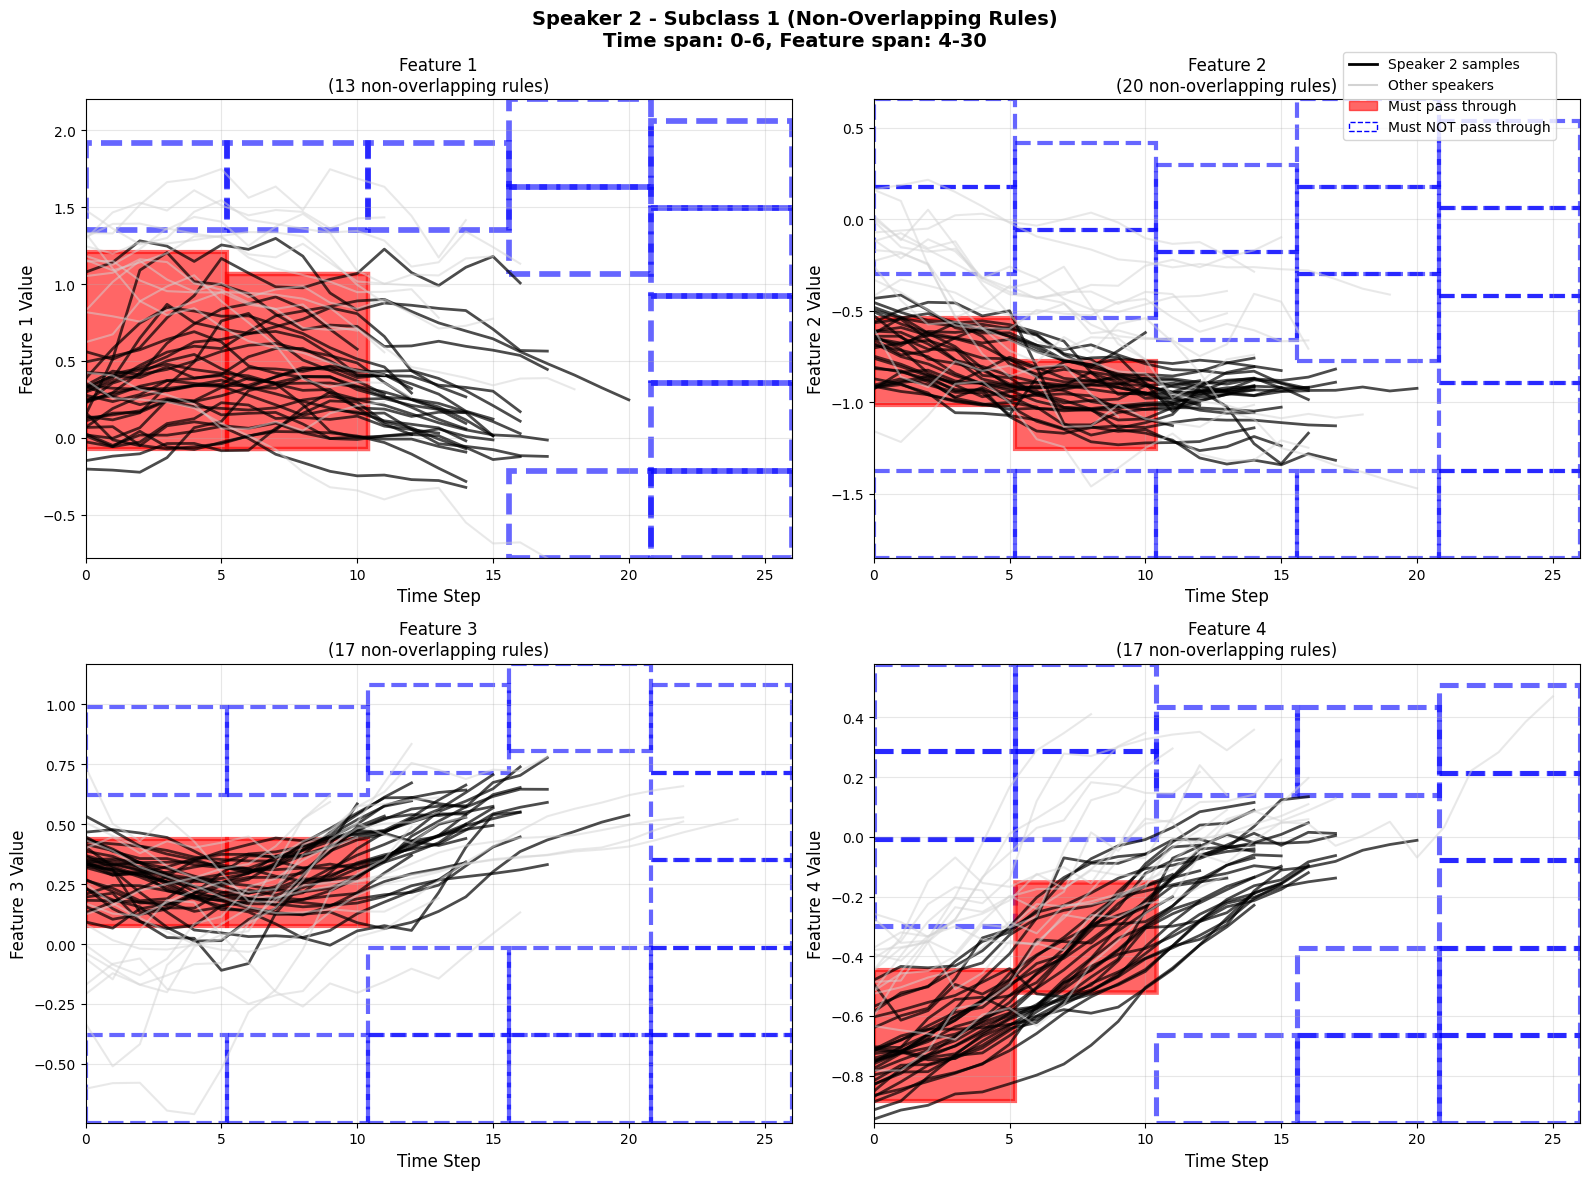

Using U=6 time thresholds, V=22 feature thresholds
Looking for rectangles with time span 0-5 and feature span 4-30

Feature 5: 1261 total -> 16 non-overlapping

Feature 6: 960 total -> 15 non-overlapping

Feature 7: 1248 total -> 15 non-overlapping

Feature 8: 1295 total -> 16 non-overlapping


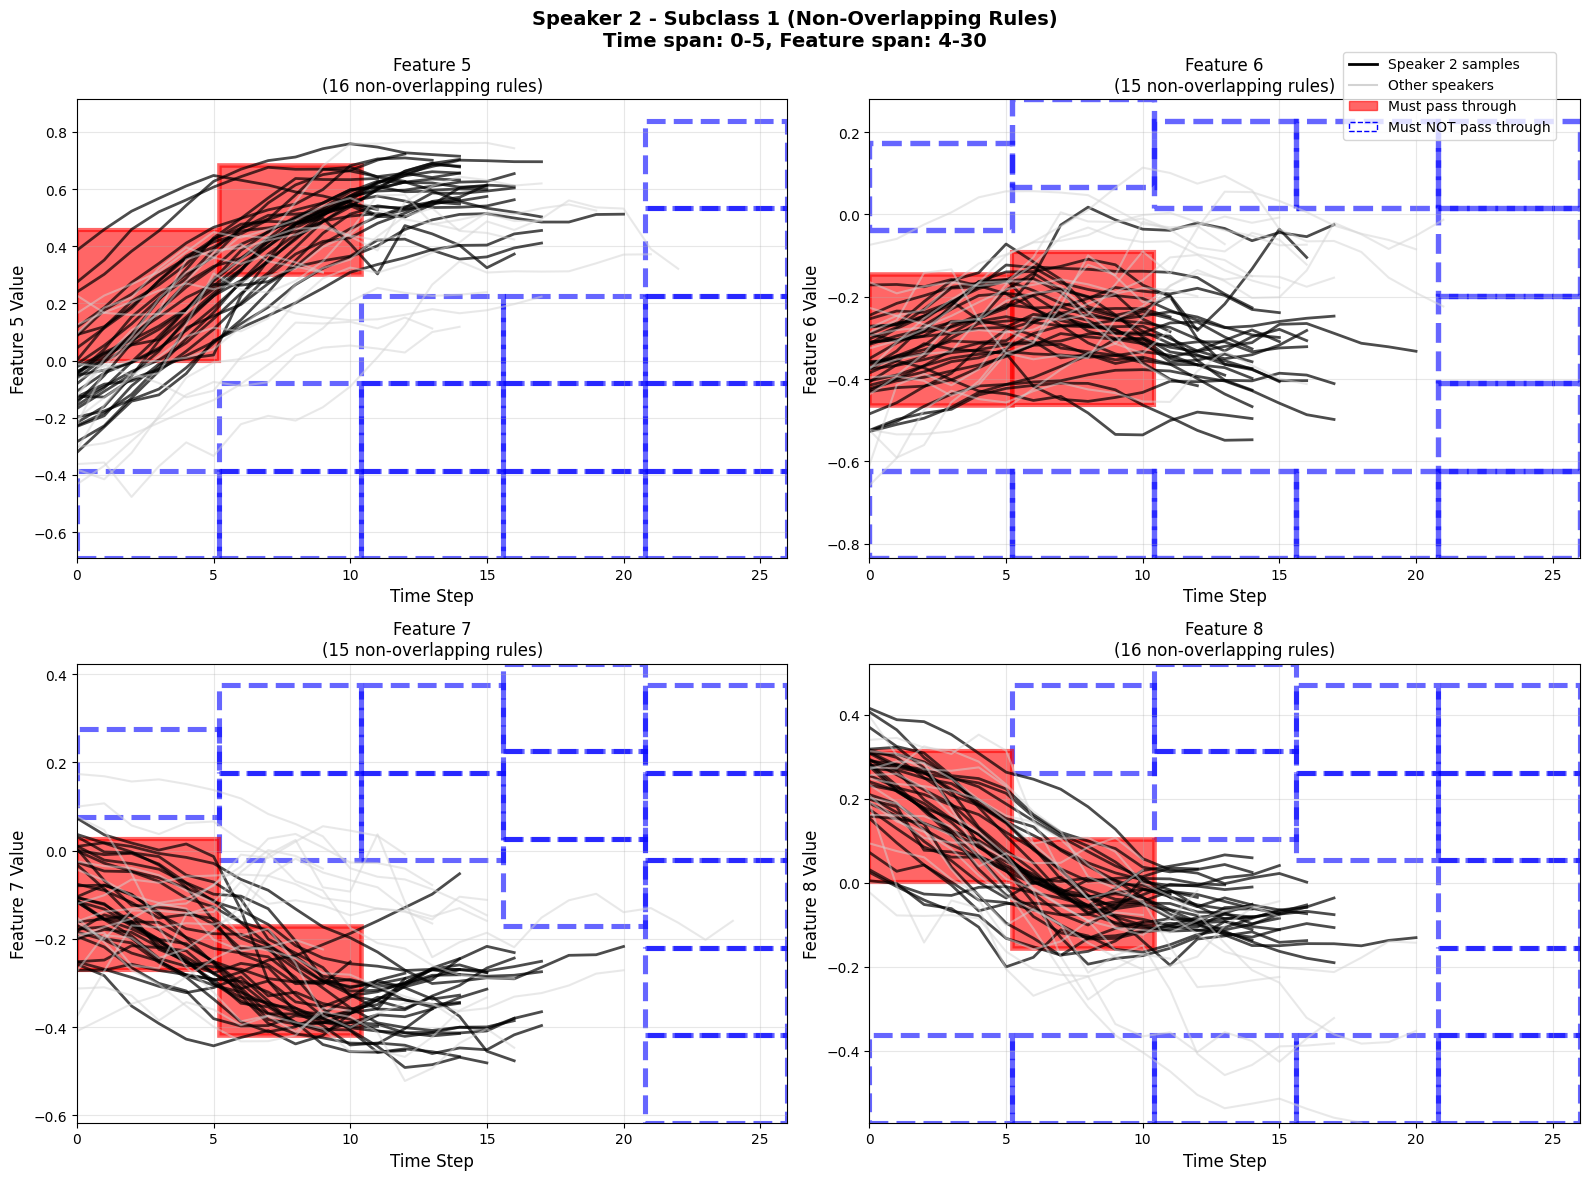

Using U=6 time thresholds, V=22 feature thresholds
Looking for rectangles with time span 0-5 and feature span 4-30

Feature 9: 993 total -> 14 non-overlapping

Feature 10: 1092 total -> 15 non-overlapping

Feature 11: 843 total -> 12 non-overlapping

Feature 12: 1230 total -> 14 non-overlapping


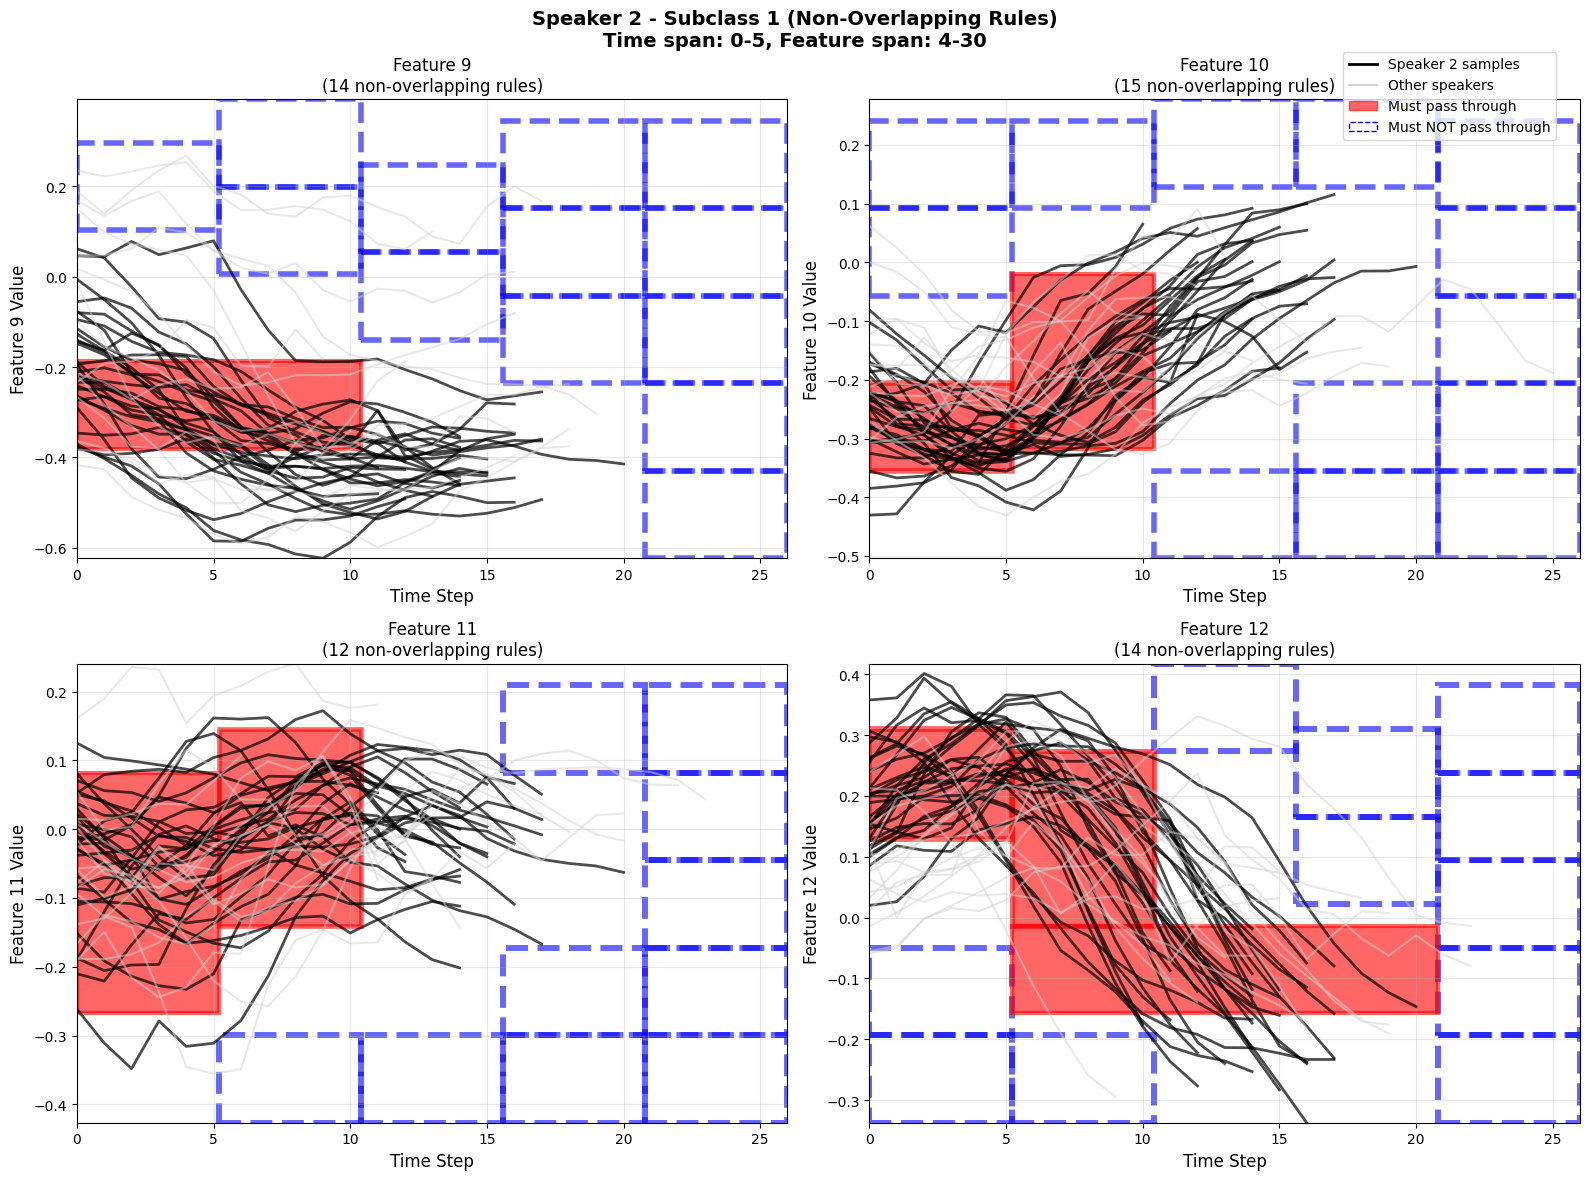

In [198]:
visualize_meaningful_rectangles_no_overlap(speaker_id=2, subclass_idx=0, feature_dims=[0,1,2,3],
                                         min_time_span=0, max_time_span=6,
                                         min_feature_span=4, max_feature_span=30, max_rectangles_per_plot=50)

visualize_meaningful_rectangles_no_overlap(speaker_id=2, subclass_idx=0, feature_dims=[4,5,6,7],
                                         min_time_span=0, max_time_span=5,
                                         min_feature_span=4, max_feature_span=30, max_rectangles_per_plot=50)

visualize_meaningful_rectangles_no_overlap(speaker_id=2, subclass_idx=0, feature_dims=[8,9,10,11],
                                         min_time_span=0, max_time_span=5,
                                         min_feature_span=4, max_feature_span=30, max_rectangles_per_plot=50)
